### Do we get any improvement in resolution by accounting for the focus curvature in our binning procedure?

In [1]:
# Initialize stuff
import matplotlib
matplotlib.use('nbagg')
import numpy as np

from xraycam import camcontrol
from xraycam.camcontrol import plt

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

def runset_and_merge(run_prefix, number_runs, run = False, threshold_min = 31, threshold_max =  55, **kwargs):
    """Returns a Frame"""
    runset = camcontrol.RunSet(run_prefix= run_prefix,
        run = run, number_runs = number_runs, **kwargs)
    return runset.filter_reduce_frames(threshold_min = threshold_min, threshold_max = threshold_max)
def runset_merge_plot(*args, rebin = 10, **kwargs):
    frame = runset_and_merge(*args, **kwargs)
    return frame.plot_lineout(rebin = rebin)

In [103]:
def parabolic_sort(a, b, shape = (1024, 1280)):
    """
    Returns: z, (rowsort, colsort)
    
    z : 2d numpy array of shape `shape` with values x**2 + b * x + c,
    where x is row index.
    rowsort : sequence of row indices that sort z
    colsort : sequence of column indices that sort z
    """
    x, y = np.indices(shape, dtype = 'int')
    z = ((a * (x**2)) + (b * x) + y)
    return z, np.unravel_index(
                np.argsort(z.ravel()), z.shape)


def center_of_masses(arr2d):
    def _cm(arr1d):
        return np.dot(arr1d, np.arange(len(arr1d)))/np.sum(arr1d)
    return np.array(list(map(_cm, arr2d)))

def quadfit(arr2d, smooth = 10):
    """
    Return the second- and first-order coefficients for a parabolic
    fit to array of center of mass values of the rows of arr2d.
    """
    filtered = gfilt(arr2d, 10)
    y = center_of_masses(filtered)# - np.percentile(filtered, 1))
    x = np.arange(len(y))
    good = np.where(np.isfinite(y))[0]
    a, b, c, = np.polyfit(x[good], y[good], 2)
    # For some reason a factor of -1 is needed
    return -a, -b, -c

def get_parabolic_lineout(arr2d, nbins = None):
    """Return lineout taken using parabolic bins"""
    a, b, _ = quadfit(arr2d)
    num_rows, num_cols = arr2d.shape
    if nbins is None:
        nbins = num_cols
    def chunks():
        """Return array values grouped into chunks, one per bin"""
        increment = int(num_rows * (num_cols/nbins))
        _, sort_indices = parabolic_sort(a, b, arr2d.shape)
        sort_data = arr2d[sort_indices].ravel()
        return [sort_data[i:i + increment] for i in range(0, len(sort_data), increment)]
    return np.array(list(map(np.sum, chunks())))

psurface, sort_indices = parabolic_sort(-7.23224111e-05,  8.57453753e-02)


### Import test data:

In [9]:
frame2 = runset_and_merge('data/5.20.longrun0', 18, gain = '0x3f',
        numExposures = 2000, run = False, window_min = 31, window_max = 55,
        threshold_min = 31, threshold_max = 55)

In [59]:
import matplotlib.pyplot as mplt
def plot_parabolas(arr2d, interval = 10):
    a, b, _ = quadfit(arr2d)
    a, b = -a, -b
    x = np.arange(arr2d.shape[0])
    parabolas = [a * x**2 + b * x + c for c in range(0, arr2d.shape[1], interval)]
    [mplt.plot(p, x) for p in parabolas]

In [104]:
# We exclude the top and bottom of the frame to avoid boundary artifacts
#exclude_region = 0
#arr2d = frame2.data#[250:-250, 500:800]

def normlineout(dat):
    lineout = np.sum(dat, axis = 0)
    return lineout/np.max(lineout)

def dofit(arr2d):

    y = center_of_masses(arr2d)
    x = np.arange(len(y))
    plt.plot(x, y, label = 'CM lineout')

    a, b, c = quadfit(arr2d)
    plt.plot(x, -a * x**2 - b * x - c)
    plt.show()

    # Also the 2d array overlaid with some of the bin-defining parabolas
    mplt.imshow(arr2d, vmax = 200)
    plot_parabolas(arr2d, interval = 15)
    mplt.show()
    
    plt.plot(get_parabolic_lineout(arr2d), label = 'parabolic lineout')
    #col_lineout = normlineout(arr2d)
    plt.plot(np.sum(arr2d, axis = 0), label = 'column lineout')
    plt.show()

    print(a, b, c) 

<IPython.core.display.Javascript object>


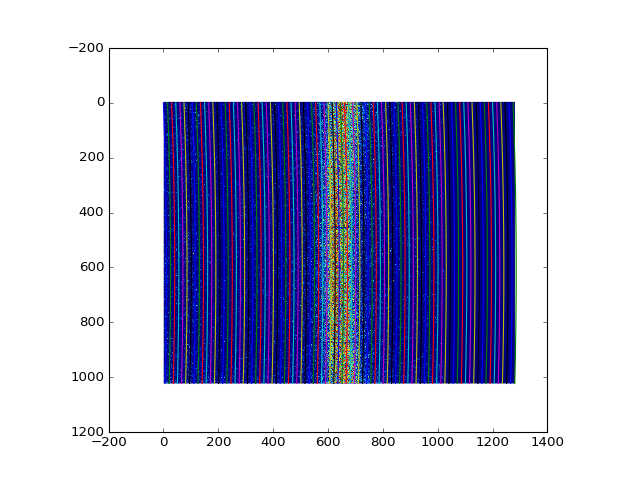

-2.99358949281e-05 0.0364971584764 -616.872909141


In [8]:
dofit(frame2.data)

<IPython.core.display.Javascript object>


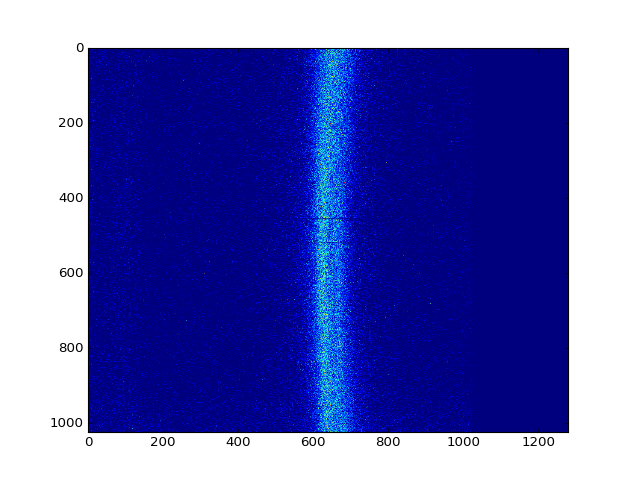

In [6]:
frame2.show()

### Fit looks reasonable; but the new binning procedure doesn't give much (or any) improvement:

In [7]:
#plt.plot(get_parabolic_lineout(cropped), label = 'quad1')
def normlineout(dat):
    lineout = np.sum(dat, axis = 0)
    return lineout/np.max(lineout)
[plt.plot(normlineout(dat), label = 'lin1') for dat in [frame2.data[250:750], frame2.data, frame2.data[400:800],frame2.data[600:700]]]

#plt.plot(np.sum(subregion, axis = 0), label = 'lin2')
#plt.plot(get_parabolic_lineout(subregion), label = 'quad2')
plt.show()

In [106]:
pkb_long = np.genfromtxt('6.4.longarr.txt')[:900, :1200]
#pkb_long -= np.mean(pkb_long[:, :300])

In [107]:
np.percentile(gfilt(pkb_long, 10), 1)

10.557131707891706

<IPython.core.display.Javascript object>


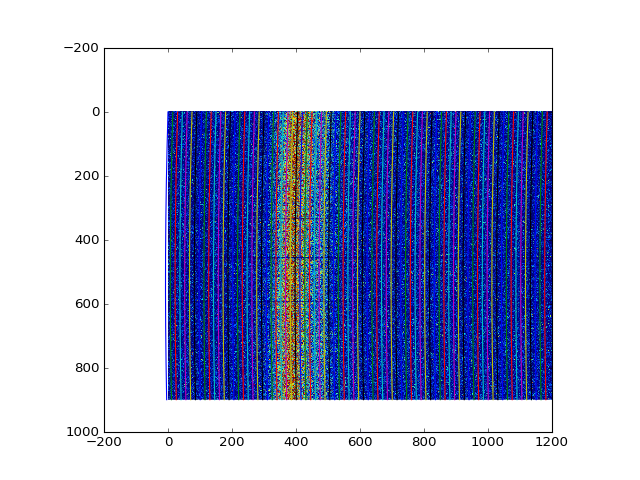

-2.74925510574e-05 0.0293396944985 -516.02452842


In [108]:
dofit(pkb_long)

In [115]:
plt.plot(normlineout(pkb_long), label = 'full frame')
plt.plot(normlineout(pkb_long[400:600]), label = 'center')
plt.show()

In [109]:
from scipy.ndimage.interpolation import rotate as rot

In [110]:
rotated = rot(pkb_long, 10)[200:-200, 300:680] - 9.4

<IPython.core.display.Javascript object>


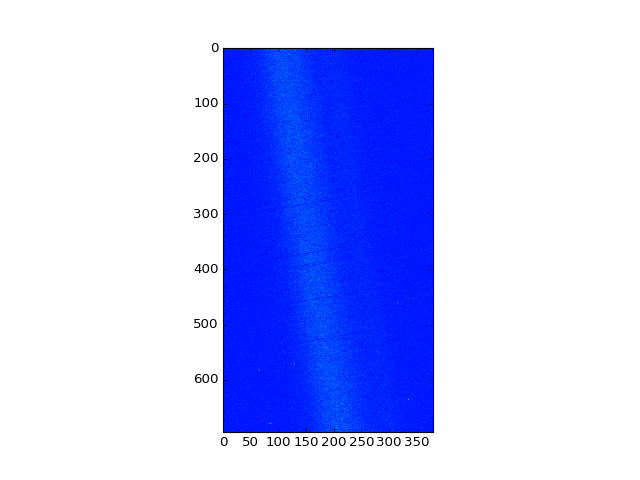

In [111]:
plt.imshow(rotated)
plt.show()

<IPython.core.display.Javascript object>


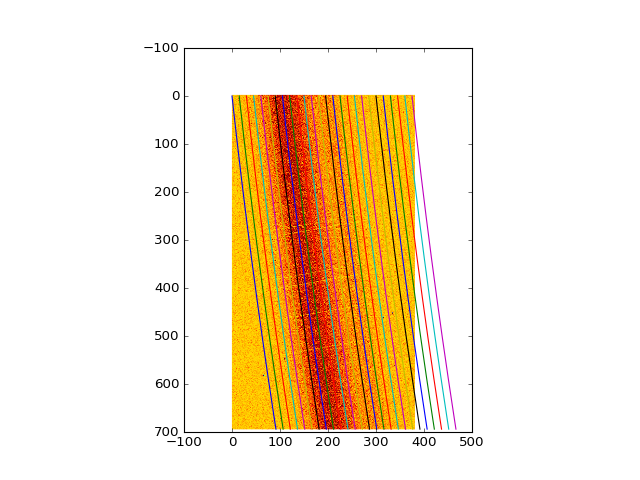

-3.31942428348e-05 -0.108860503225 -130.718809444


In [112]:
dofit(rotated)